In [1]:
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import gym, gym.spaces
import logging
import matplotlib.pyplot as plt
%matplotlib inline

logging.basicConfig(level=logging.DEBUG)

Instructions for updating:
non-resource variables are not supported in the long term


In [0]:
# parameters
state_size = 7040
hidden_size = 40
save_dir = './save_dqn/'

In [0]:
mspacman_color = 210 + 164 + 74
# preprocess function
def preprocess(image, first=False):
    """ prepro 210x160x3 uint8 frame into 6400 (or 80x80) 2D float array """
    image = image[1:176:2,::2] # crop and downsize
    image = image.sum(axis=2) # greyscale
    image[image == mspacman_color] = 0 # improve contrast
    image = (image//3 -128).astype(np.int8) # normalize from -128 to 127
    if first:
        return np.reshape(image.astype(np.float).ravel(), [1,80,80,1])
    else:
        return np.reshape(image.astype(np.float).ravel(), 7040)

In [0]:
# Deep Q Network setup
class DeepQNetwork:

    def __init__(self, n_actions, n_features, learning_rate=0.01, reward_decay=0.99, e_greedy=0.9, update_params_step=300, buffer_size=500,
            batch_size=32, output_graph=False, hidden_size = 20, save_dir = './save_dqn/'):
        
        self.n_actions = n_actions
        self.n_features = n_features
        self.lr = learning_rate
        self.gamma = reward_decay
        self.replace_target_iter = update_params_step
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.epsilon = e_greedy
        self.save_dir = save_dir

        self.learn_step_counter = 0
        self.memory = np.zeros((self.buffer_size, n_features * 2 + 2))

        # target_net, evaluate_net
        self._build_net()
        t_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='target_q_net')
        e_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='eval_q_net')

        with tf.variable_scope('updating', reuse=tf.AUTO_REUSE):
            self.target_replace_op = [tf.assign(t, e) for t, e in zip(t_params, e_params)]

        self.sess = tf.Session()

        if output_graph:
            tf.summary.FileWriter("logs/", self.sess.graph)

        self.sess.run(tf.global_variables_initializer())

        self.loss_his = []
        self.max_q = []

    def _build_net(self):
        ## initialize inputs
        self.inputs_ = tf.placeholder(tf.float32, [None, self.n_features], name='inputs')  
        self.next_state_ = tf.placeholder(tf.float32, [None, self.n_features], name='next_state')  
        self.reward_ = tf.placeholder(tf.float32, [None, ], name='reward')  
        self.actions_ = tf.placeholder(tf.int32, [None, ], name='actions') 

        w_initializer, b_initializer = tf.random_normal_initializer(0., 0.3), tf.constant_initializer(0.1)

        ## evaluate net
        with tf.variable_scope('eval_net', reuse=tf.AUTO_REUSE):
            e1 = tf.layers.dense(self.inputs_, units=hidden_size, activation=tf.nn.relu, kernel_initializer=w_initializer, name='eval')
            self.q_eval = tf.layers.dense(e1, units = self.n_actions, kernel_initializer=w_initializer,
                                          bias_initializer=b_initializer, name='Q')

        ## target_net
        with tf.variable_scope('target_net', reuse=tf.AUTO_REUSE):
            t1 = tf.layers.dense(self.next_state_, units = hidden_size, activation=tf.nn.relu, kernel_initializer=w_initializer, name='target1')
            self.q_next = tf.layers.dense(t1, self.n_actions, kernel_initializer=w_initializer,
                                          bias_initializer=b_initializer, name='target2')

        # target Q 
        with tf.variable_scope('q_target', reuse=tf.AUTO_REUSE):
            q_target = self.reward_ + self.gamma * tf.reduce_max(self.q_next, axis=1, name='max_Q_')    
            self.q_target = tf.stop_gradient(q_target)
        # evaluted Q 
        with tf.variable_scope('q_eval', reuse=tf.AUTO_REUSE):
            action_idx = tf.stack([tf.range(tf.shape(self.actions_)[0], dtype=tf.int32), self.actions_], axis=1)
            self.q_eval_wrt_a = tf.gather_nd(params=self.q_eval, indices=action_idx) 
        #calculate loss
        with tf.variable_scope('loss', reuse=tf.AUTO_REUSE):
            self.loss = tf.reduce_mean(tf.squared_difference(self.q_target, self.q_eval_wrt_a, name='TD_error'))
        #train the network
        with tf.variable_scope('train', reuse=tf.AUTO_REUSE):
            self._train_op = tf.train.RMSPropOptimizer(self.lr).minimize(self.loss)

    def store_transition(self, oldstate, action, reward, newstate):
        if not hasattr(self, 'memory_counter'):
            self.memory_counter = 0
        transition = np.hstack((oldstate, [action, reward], newstate))
        # update state 
        index = self.memory_counter % self.buffer_size
        self.memory[index, :] = transition
        self.memory_counter += 1

    def choose_action(self, state):
        #update actions based on policy
        state = state[np.newaxis, :]
        # If off policy, random action
        if np.random.uniform() < self.epsilon:
            actions_value = self.sess.run(self.q_eval, feed_dict={self.inputs_: state})
            action = np.argmax(actions_value)
        else:
            action = np.random.randint(0, self.n_actions)
        return action


    def train(self):    
        # update target parameters each iteration
        if self.learn_step_counter % self.replace_target_iter == 0:
            self.sess.run(self.target_replace_op)

        # sample the memory as it exceeds the size
        if self.memory_counter > self.buffer_size:
            sample_index = np.random.choice(self.buffer_size, size=self.batch_size)
        else:
            sample_index = np.random.choice(self.memory_counter, size=self.batch_size)
        batch_memory = self.memory[sample_index, :]

        # train the nextwork
        _, loss, q_n = self.sess.run(
            [self._train_op, self.loss, self.q_eval_wrt_a],
            feed_dict={
                self.inputs_: batch_memory[:, :self.n_features],
                self.actions_: batch_memory[:, self.n_features],
                self.reward_: batch_memory[:, self.n_features + 1],
                self.next_state_: batch_memory[:, -self.n_features:],
            })

        self.loss_his.append(loss)
        self.max_Q.append(np.max(q_n))

        # update the counter
        self.learn_step_counter += 1

    def plot_loss(self):
        plt.plot(np.arange(len(self.loss_his)), self.loss_his)
        plt.ylabel('Loss')
        plt.xlabel('Training steps')
        plt.show()
    
    def plot_max_Q(self):
        self.mean_max_Q = [x[0]/x[1] for x in list(zip(np.cumsum(self.max_Q), range(1,len(self.max_Q)+1)))]
        plt.plot(np.arange(len(self.mean_max_Q)), self.mean_max_Q)
        plt.ylabel('Mean of Max Q Value')
        plt.xlabel('Training steps')
        plt.show()  
        
    def save_model(self):
        self.ckpts_path = self.save_dir + "dqn.ckpt"
        self.saver = tf.train.Saver()
        self.saver.save(self.sess, self.ckpts_path)

In [0]:
def run_DQN(episodes):
    
    step = 0
    for episode in range(episodes):

        state = env.reset()

        while True:          
            
            action = RL.choose_action(preprocess(state))
            newstate, reward, done, _ = env.step(action)
            
            RL.store_transition(preprocess(state), action, reward, preprocess(newstate))            
            # train from episodes
            if (step > 200) and (step % 5 == 0):
                RL.train()

            state = newstate

            # If done, reset history
            if done:
                if episode % 10 == 0:
                    logging.info('Finsihed episode {}'.format(str(episode)))
                break
            step += 1

    logging.info('Game Over')
    env.close()

In [0]:
def play(episodes=1000):
    
    saver = tf.train.Saver()
    saver.restore(RL.sess, RL.ckpts_path)

    step = 0
    
    rewards = []

    for episode in range(episodes):

        total_reward = 0
        state = env.reset()

        while True:
            
            action = RL.choose_action(preprocess(state))
            newstate, reward, done, _ = env.step(action)
            
            # Increment reward
            total_reward += reward

            # next state as the current
            state = newstate

            # break at end of an episode
            if done:
                rewards.append(total_reward)
                break
            step += 1
        
        if episode % 10 == 0:
            logging.info('Episodes: {0}\t current Reward:{1}'.format(episode, reward))

    logging.info('Game Over')
    env.close()
    
    plt.plot(np.arange(len(rewards)), rewards)
    plt.ylabel('Total Reward')
    plt.xlabel('Episode')
    plt.show()

Instructions for updating:
Use keras.layers.Dense instead.


Instructions for updating:
Use keras.layers.Dense instead.


Instructions for updating:
Please use `layer.__call__` method instead.


Instructions for updating:
Please use `layer.__call__` method instead.


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:root:Finsihed episode 0
INFO:root:Finsihed episode 10
INFO:root:Finsihed episode 20
INFO:root:Finsihed episode 30
INFO:root:Finsihed episode 40
INFO:root:Finsihed episode 50
INFO:root:Finsihed episode 60
INFO:root:Finsihed episode 70
INFO:root:Finsihed episode 80
INFO:root:Finsihed episode 90
INFO:root:Finsihed episode 100
INFO:root:Finsihed episode 110
INFO:root:Finsihed episode 120
INFO:root:Finsihed episode 130
INFO:root:Finsihed episode 140
INFO:root:Finsihed episode 150
INFO:root:Finsihed episode 160
INFO:root:Finsihed episode 170
INFO:root:Finsihed episode 180
INFO:root:Finsihed episode 190
INFO:root:Finsihed episode 200
INFO:root:Finsihed episode 210
INFO:root:Finsihed episode 220
INFO:root:Finsihed episode 230
INFO:root:Finsihed episode 240
INFO:root:Finsihed episode 250
INFO:root:Finsihed episode 260
INFO:root:Finsihed episode 270
INFO:root:Finsihed episod

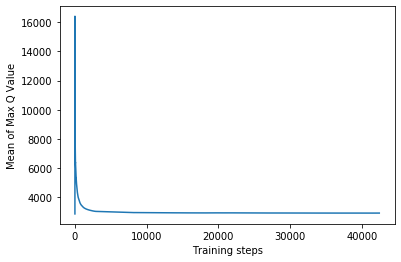

INFO:tensorflow:Restoring parameters from ./save_dqn/dqn_pc.ckpt


INFO:tensorflow:Restoring parameters from ./save_dqn/dqn_pc.ckpt
INFO:root:Episodes: 0	 current Reward:0.0
INFO:root:Episodes: 10	 current Reward:0.0
INFO:root:Episodes: 20	 current Reward:0.0
INFO:root:Episodes: 30	 current Reward:0.0
INFO:root:Episodes: 40	 current Reward:0.0
INFO:root:Episodes: 50	 current Reward:0.0
INFO:root:Episodes: 60	 current Reward:0.0
INFO:root:Episodes: 70	 current Reward:0.0
INFO:root:Episodes: 80	 current Reward:0.0
INFO:root:Episodes: 90	 current Reward:0.0
INFO:root:Episodes: 100	 current Reward:0.0
INFO:root:Episodes: 110	 current Reward:0.0
INFO:root:Episodes: 120	 current Reward:0.0
INFO:root:Episodes: 130	 current Reward:0.0
INFO:root:Episodes: 140	 current Reward:0.0
INFO:root:Episodes: 150	 current Reward:0.0
INFO:root:Episodes: 160	 current Reward:0.0
INFO:root:Episodes: 170	 current Reward:0.0
INFO:root:Episodes: 180	 current Reward:0.0
INFO:root:Episodes: 190	 current Reward:0.0
INFO:root:Episodes: 200	 current Reward:0.0
INFO:root:Episodes: 21

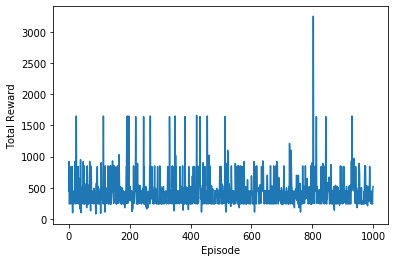

In [7]:
if __name__ == "__main__":

    # Pacman game
    env = gym.make("MsPacman-v0")

    RL = DeepQNetwork(env.action_space.n, state_size,
                      learning_rate=0.009,
                      reward_decay=0.99,
                      e_greedy=0.9,
                      update_params_step=200,
                      buffer_size=2000,
                      hidden_size=20
                      # output_graph=True
                      )
    
    run_DQN(episodes=300)
    
    RL.plot_max_q()
    RL.save_model()
    
    play(episodes=1000)